In [142]:
from pandas import datetime
#from matplotlib import pyplot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


            Accidents
Date                 
2016-02-01        985
2016-03-01       6329
2016-04-01      18088


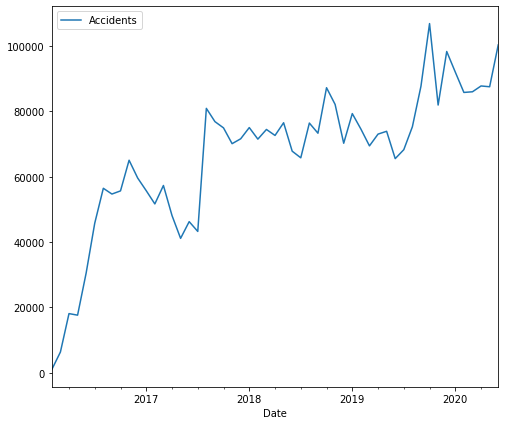

In [154]:
df= pd.read_csv('DailyAccidents2.csv', parse_dates = ['Date'], index_col = ['Date'])

print(df.head(3))
df.plot(figsize=(8,7))
plt.show()

In [165]:
df.tail(3)

,Accidents
Date,
2020-04-01,87730
2020-05-01,87490
2020-06-01,100296


In [166]:
df.size

53

In [156]:
result = adfuller(df['Accidents'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.7855361363823303
p-value: 0.060369714991405435
Critical Values:
	1%: -3.562878534649522
	5%: -2.918973284023669
	10%: -2.597393446745562


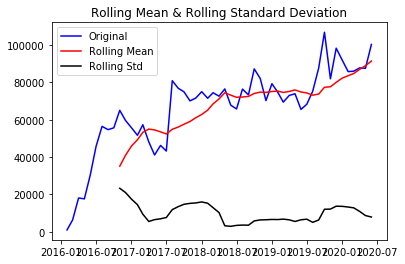

In [167]:
rolling_mean = df.rolling(window = 10).mean()
rolling_std = df.rolling(window = 10).std()

plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

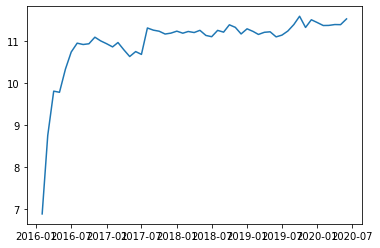

In [158]:
df_log = np.log(df)
plt.plot(df_log)

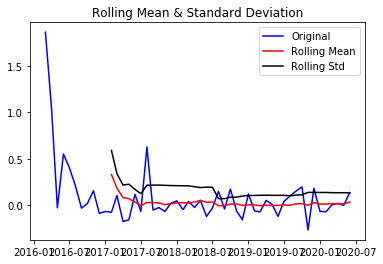

ADF Statistic: -4.74620403338398
p-value: 6.884972154529272e-05
Critical Values:
	1%: -3.6055648906249997
	5%: -2.937069375
	10%: -2.606985625


In [159]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [160]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Accidents'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

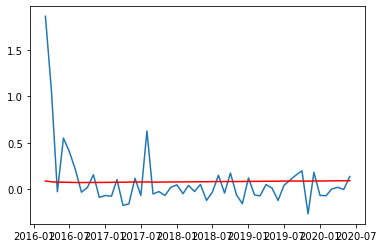

In [161]:
decomposition = seasonal_decompose(df_log) 
model1 = ARIMA(df_log, order=(1,1,1))
results = model1.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.show()

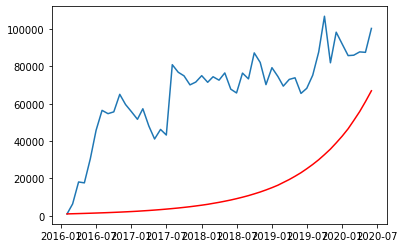

In [162]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Accidents'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA, color="red")

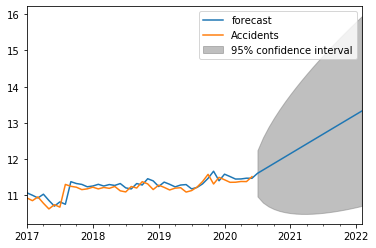

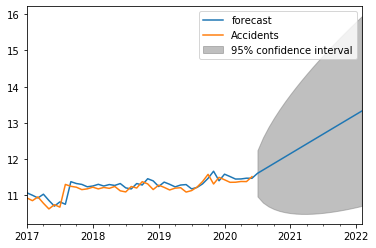

In [170]:

results.plot_predict(11,72)

predicted=86500.236951, expected=70205.000000
predicted=73226.403368, expected=79276.000000
predicted=80608.863530, expected=74559.000000
predicted=77681.362959, expected=69401.000000
predicted=71901.608351, expected=73001.000000
predicted=74607.298541, expected=73864.000000
predicted=75867.015215, expected=65501.000000
predicted=68197.696982, expected=68234.000000
predicted=69660.544167, expected=75246.000000
predicted=76413.099274, expected=87659.000000
predicted=88719.047617, expected=106817.000000
predicted=109084.599983, expected=81894.000000
predicted=86990.747522, expected=98281.000000
predicted=97586.290659, expected=91969.000000
predicted=96060.659761, expected=85749.000000
predicted=89386.380342, expected=85953.000000
predicted=88036.504457, expected=87730.000000
predicted=89447.088783, expected=87490.000000
predicted=89595.532225, expected=100296.000000
Test RMSE: 10604.401


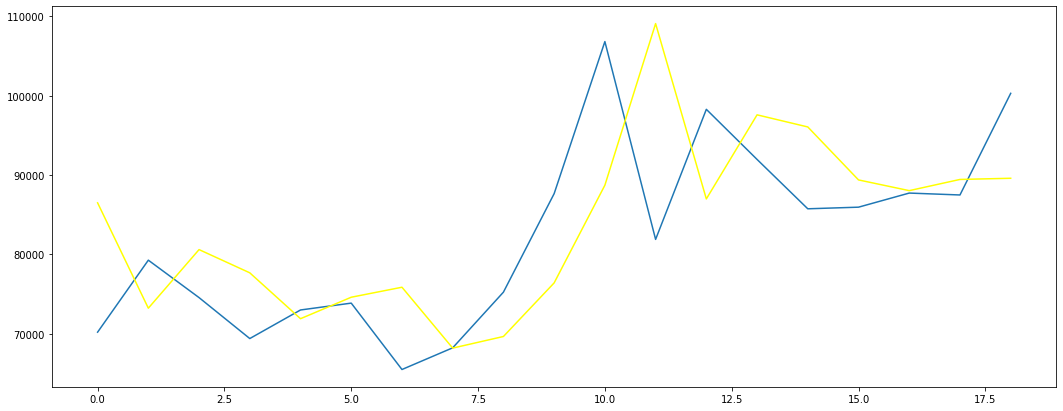

In [164]:
# split into train and test sets
X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(18,7))
plt.plot(test)
plt.plot(predictions, color='yellow')
plt.show()

In [122]:
size = int(len(X) * 0.70)
train = X[0:size]
train.shape

(37, 1)

In [123]:
test= X[size:len(X)]
test.shape

(16, 1)

In [169]:
from sklearn.metrics import r2_score
r2_score(test,predictions)

0.1291729898482502